In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import os

random_state = 23873


outdir = r'./eval/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
outdir = r'./eval/Embedded'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [2]:
dt = pd.read_csv(r'data/refined_data.csv')

In [3]:
outdir = r'./eval/Embedded/Linear'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
from sklearn.model_selection import cross_validate

In [5]:
def intermediate_results(res,mdl = ''):
    cv_res = pd.DataFrame(data = {'features': [res['features'] for res in result],
    'balanced_accuracy': [res['balanced_accuracy'] for res in result],
    'f1_macro': [res['f1_macro'] for res in result],
    'precision_macro': [res['precision_macro'] for res in result],
    'recall_macro': [res['recall_macro'] for res in result]})
    return cv_res

def intermediate_plot(res,scorer='f1_macro',mdl = ''):
    plt.rcParams["figure.figsize"] = [8.00, 5.00]
    plt.rcParams["figure.autolayout"] = True
    sns.color_palette("deep")
    sns.barplot(x = 'features',y = scorer,data = res,color='green')
    plt.xlabel('Number of Features')
    plt.ylabel(' '.join(scorer.split('_')))
    plt.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{scorer}.png'), dpi=300, bbox_inches='tight')
    plt.show()

def classifier(x_train, y_train,scoring,classifiers):
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    scores = cross_val_score(classifiers, StandardScaler().fit_transform(x_train), y_train, scoring=scoring, cv=cv)
    return scores.mean()

def feed_forward(unprocessed_cols,current_bestcols,scoring,classifiers):
    results = [classifier(features[current_bestcols + [x]], target,scoring,classifiers) for x in unprocessed_cols]
    current_bestcols = current_bestcols + [unprocessed_cols[results.index(max(results))]]
    bestcols.append((max(results), current_bestcols))
    unprocessed_cols.pop(results.index(max(results)))
    if len(unprocessed_cols) > 0:
        print(f"{len(unprocessed_cols)} columns left to process")
        feed_forward(unprocessed_cols,current_bestcols,scoring,classifiers)
    else:
        return bestcols
    
def final_results(bestcols,result,scoring='f1_macro',mdl=''):
    plt.rcParams["figure.figsize"] = [8.00, 5.00]
    plt.rcParams["figure.autolayout"] = True
    sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
    plt.xlabel('Number of Features')
    plt.ylabel(' '.join(scoring.split('_')))
    plt.savefig(os.path.join(outdir, f'{mdl}_stage2_result_with_{scoring}.png'), dpi=300, bbox_inches='tight')
    plt.show(block=False)
    
    while True:
        try:
            no_of_cols = int(input("Enter Number of Columns: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")
    
    data = {'Metric':['Stage One (No of Cols)',f'Stage One ({scoring})', 'Stage One (Columns)','Stage Two (No of Cols)', f'Stage Two ({scoring})', 'Stage Two (Columns)'],
            'Value':[peak,[x for x in result if x['features'] == peak][0][scoring],sorted([x for x in result if x['features'] == peak][0]['cols'],reverse=False),no_of_cols,bestcols[no_of_cols-1][0],sorted(bestcols[no_of_cols-1][1],reverse=False)]
           }    
    return pd.DataFrame(data),bestcols[no_of_cols-1][0]


def plot_difference(dict1,dict2):
    # Extract variable names and their differences
    variables = list(dict1.keys())
    differences = [dict1[var] - dict2[var] for var in variables]

    # Create a bar plot
    plt.barh(variables, differences, color=['green' if diff > 0 else 'red' for diff in differences])

    # Set plot title and labels
    plt.title('Variable Differences')
    plt.xlabel('Variables')
    plt.ylabel('Difference with Baseline')

    plt.savefig(os.path.join(outdir, f"{mdl}_difference_with_baseline.png"), dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

## Linear Models

### Logistic Regression

In [6]:
def feat_select_log_reg(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    clf = LogisticRegression()
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].coef_[0] for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.7628246753246753
10031 columns produced macro recall of 0.9227272727272727
5017 columns produced macro recall of 0.9647727272727273
2510 columns produced macro recall of 0.9761363636363637
1256 columns produced macro recall of 0.9886363636363636
629 columns produced macro recall of 1.0
315 columns produced macro recall of 1.0
158 columns produced macro recall of 1.0
80 columns produced macro recall of 1.0
41 columns produced macro recall of 1.0
21 columns produced macro recall of 1.0
12 columns produced macro recall of 0.9520021645021643
7 columns produced macro recall of 0.9531385281385281
5 columns produced macro recall of 0.9409090909090909
3 columns produced macro recall of 0.8645021645021644
3 columns produced macro recall of 0.8645021645021644
3 columns produced macro recall of 0.8645021645021644
3 columns produced macro recall of 0.8645021645021644
3 columns produced macro recall of 0.8645021645021644


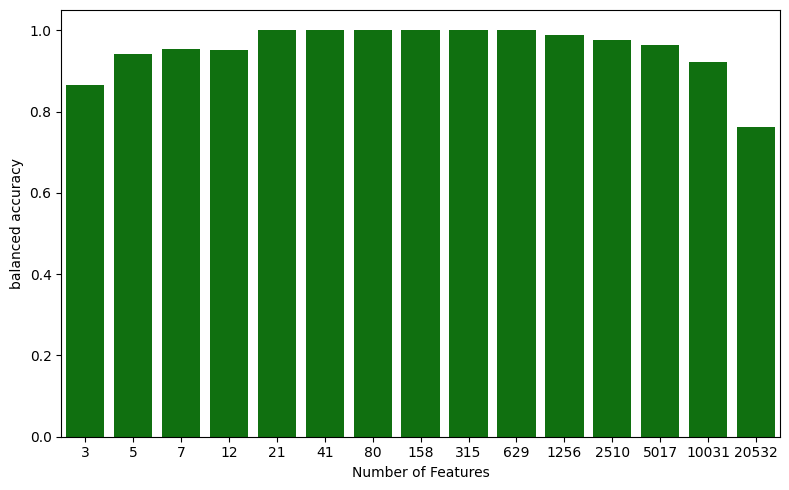

Enter Graph Peak: 21
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


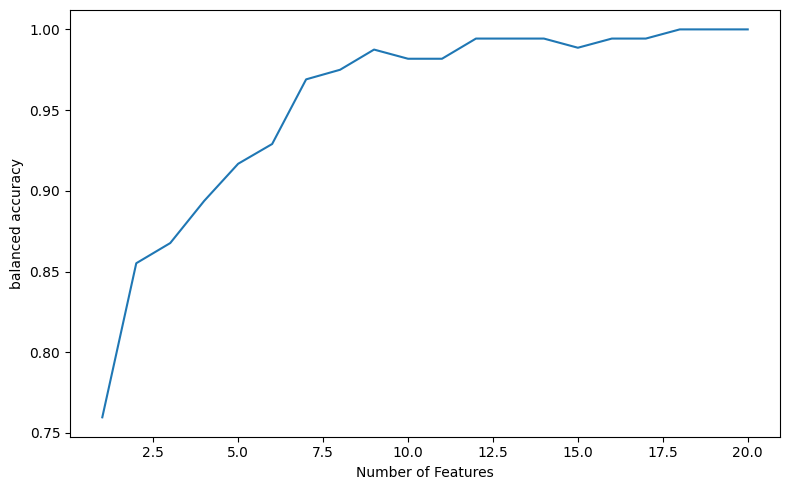

Enter Number of Columns: 9


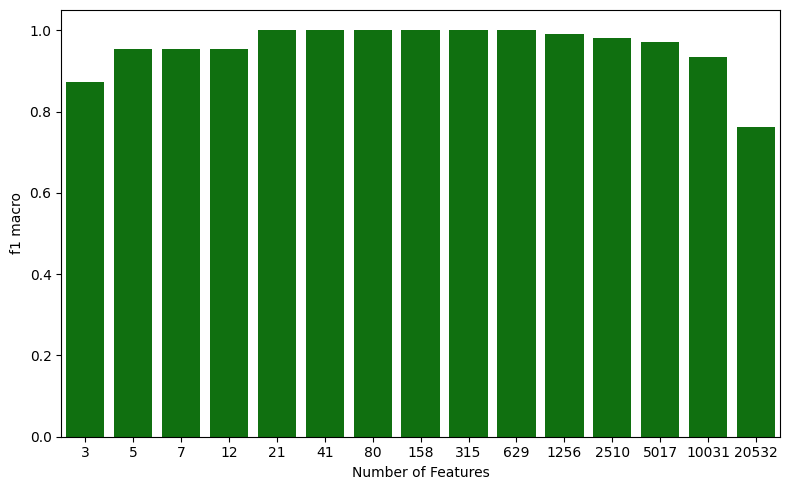

Enter Graph Peak: 21
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


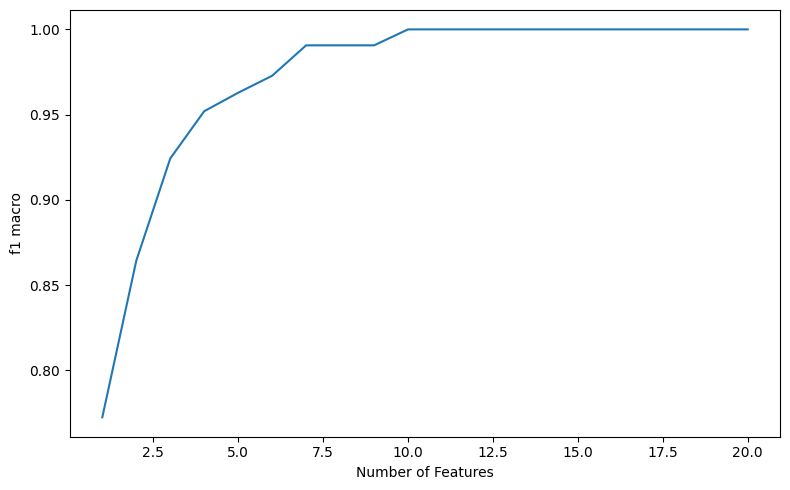

Enter Number of Columns: 8


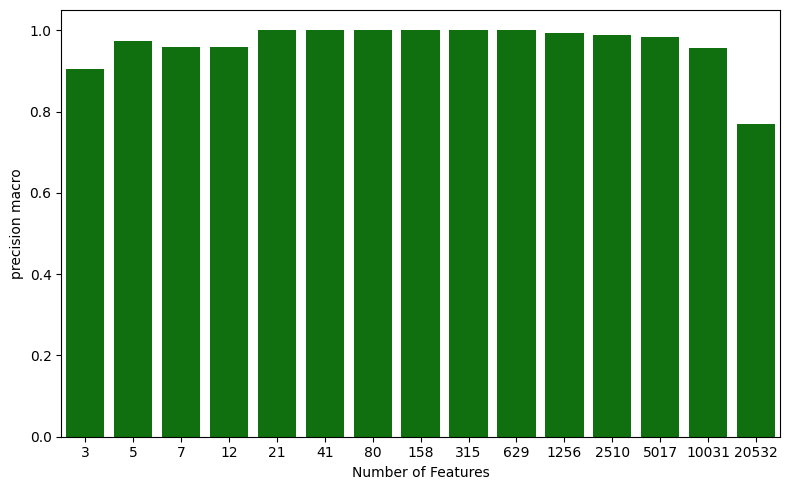

Enter Graph Peak: 21
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


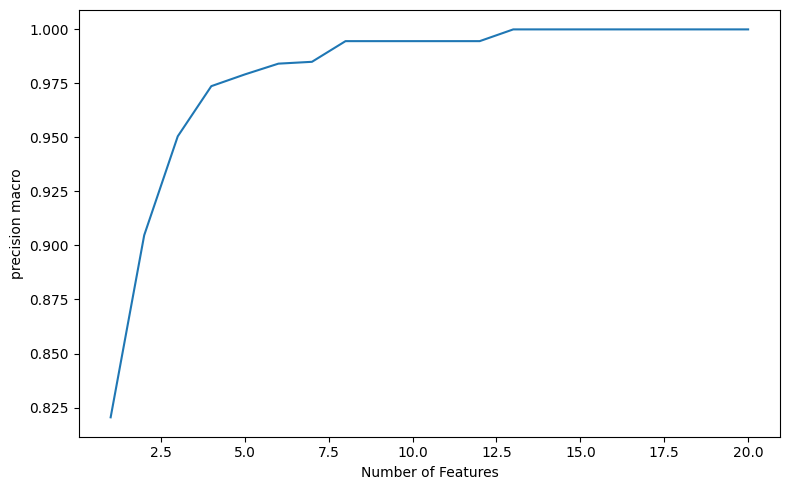

Enter Number of Columns: 8


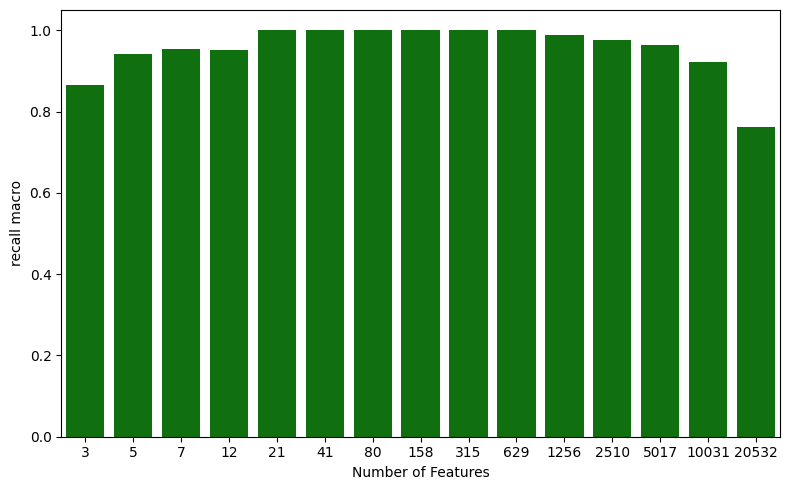

Enter Graph Peak: 21
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


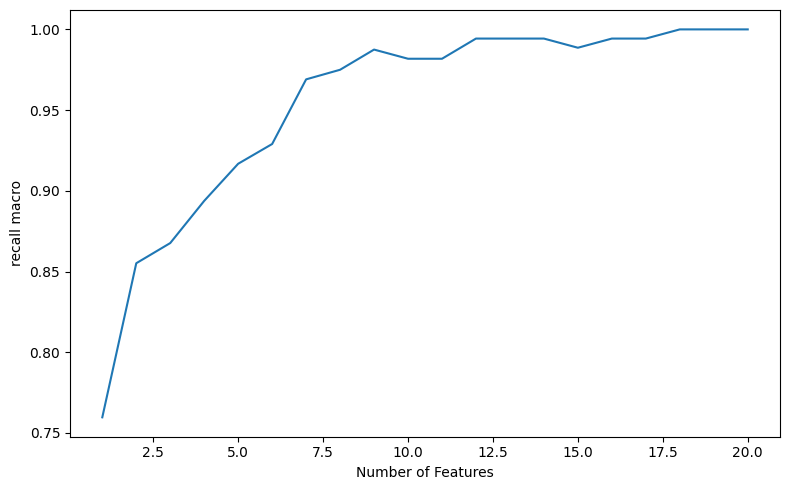

Enter Number of Columns: 8


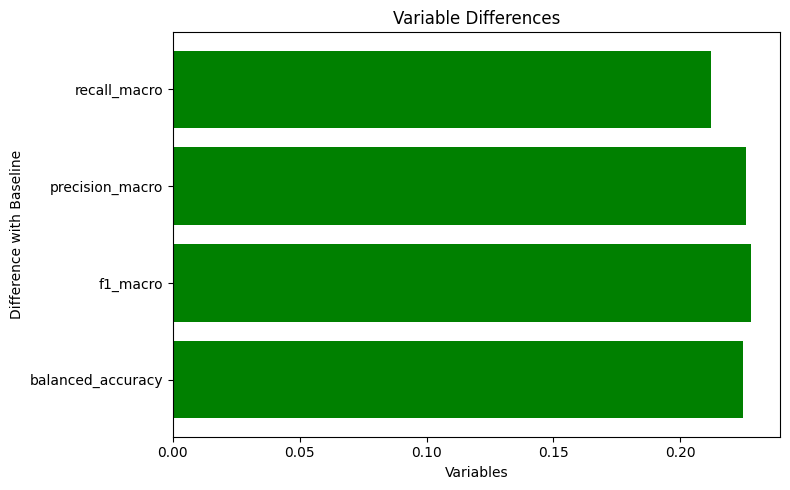

In [7]:
col = dt.columns
features = [0,1]
result= []
mdl = 'logreg'
classifiers = LogisticRegression()
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_log_reg(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])

## Ensemble

### Extra Trees

In [14]:
outdir = r'./eval/Embedded/Ensemble'
if not os.path.exists(outdir):
    os.mkdir(outdir)

outdir = r'./eval/Embedded/Ensemble/ExtraTrees'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
def feat_select_extra(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', ExtraTreesClassifier(n_estimators =10, random_state = random_state))
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].feature_importances_ for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.7083333333333333
306 columns produced macro recall of 0.7298701298701299
139 columns produced macro recall of 0.778138528138528
70 columns produced macro recall of 0.7488636363636363
36 columns produced macro recall of 0.7616883116883116
19 columns produced macro recall of 0.7838203463203464
10 columns produced macro recall of 0.8335497835497835
6 columns produced macro recall of 0.8167748917748918
4 columns produced macro recall of 0.7659632034632035
3 columns produced macro recall of 0.8014610389610389
2 columns produced macro recall of 0.6336038961038961
2 columns produced macro recall of 0.6336038961038961
2 columns produced macro recall of 0.6336038961038961
2 columns produced macro recall of 0.6336038961038961
2 columns produced macro recall of 0.6336038961038961


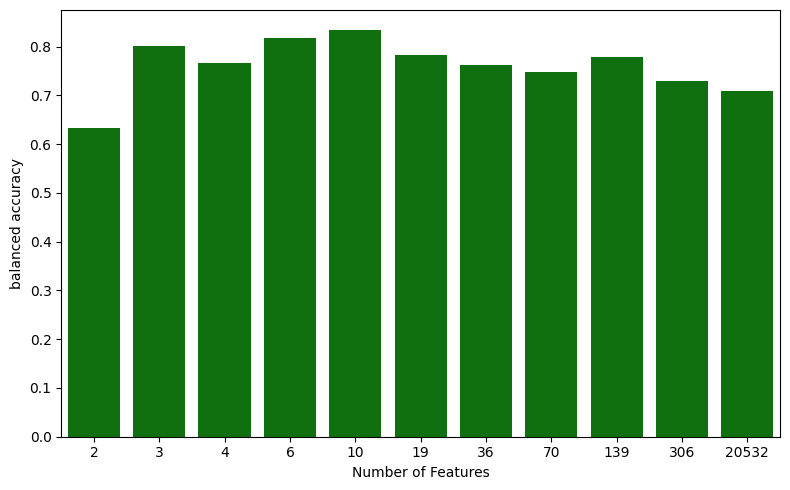

Enter Graph Peak: 19
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


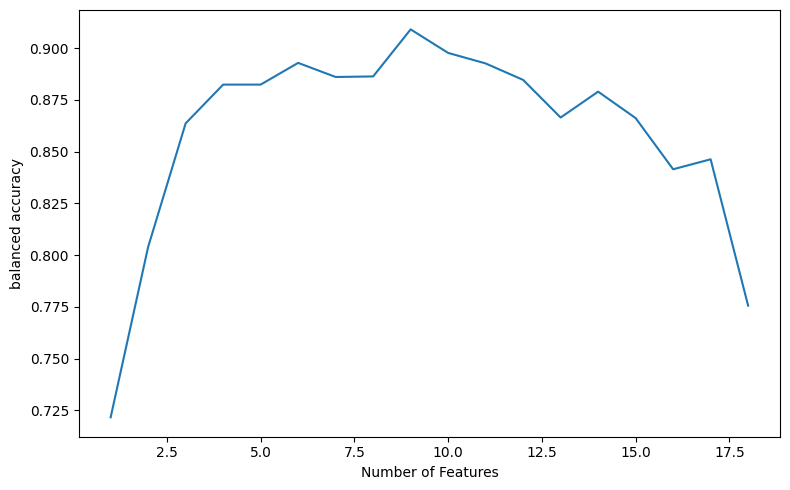

Enter Number of Columns: 9


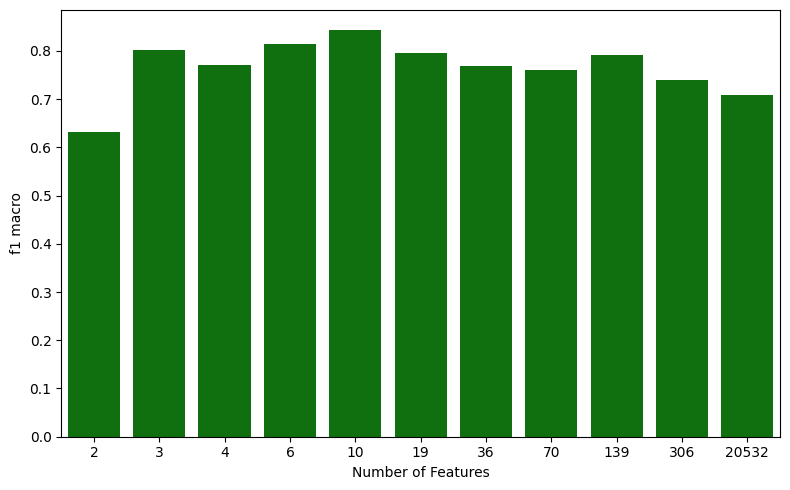

Enter Graph Peak: 19
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


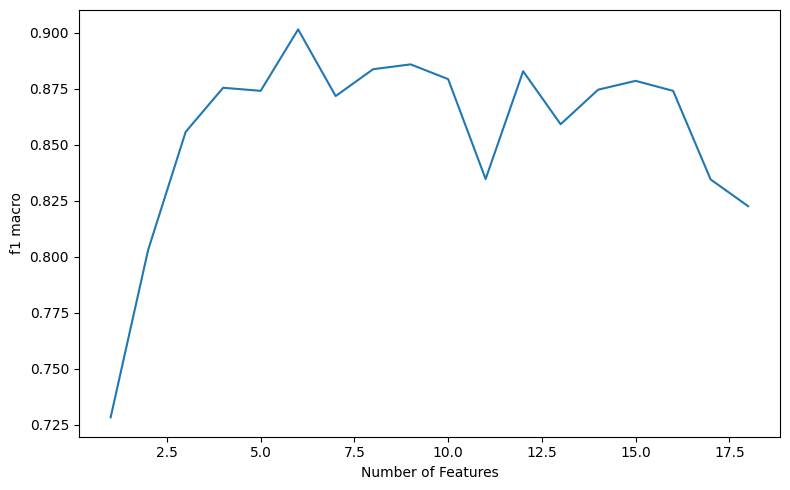

Enter Number of Columns: 6


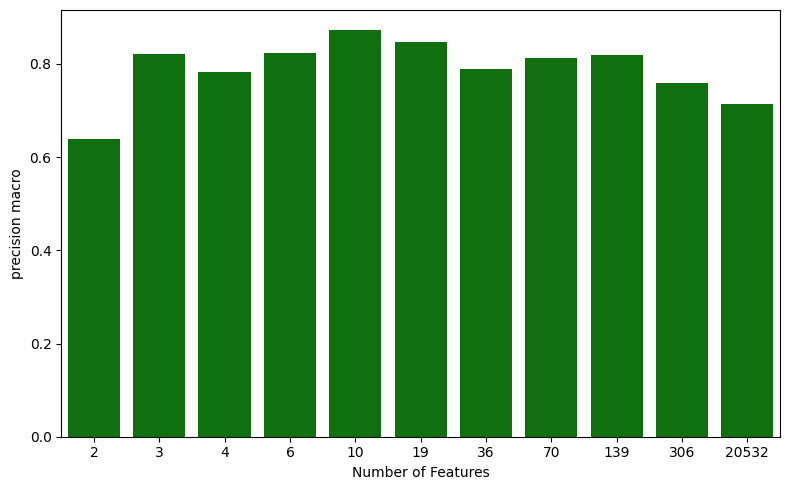

Enter Graph Peak: 19
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


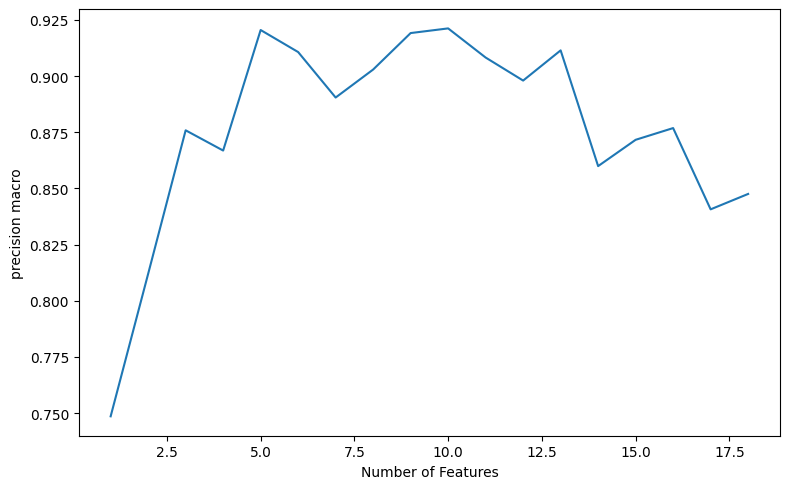

Enter Number of Columns: 6


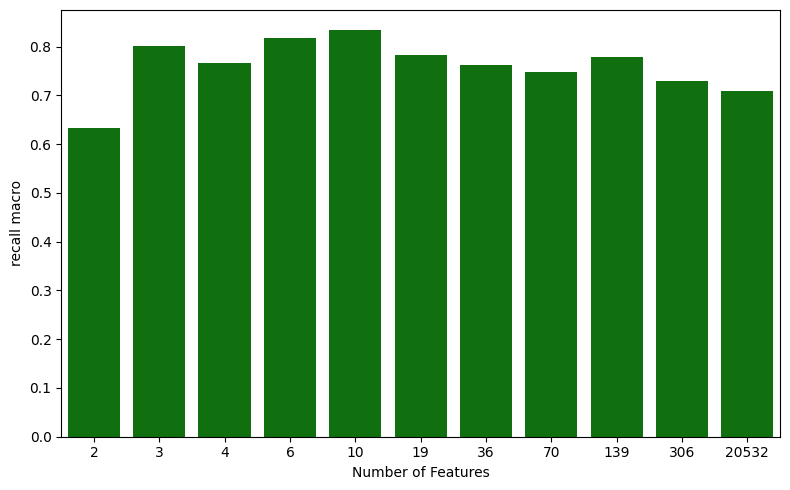

Enter Graph Peak: 19
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


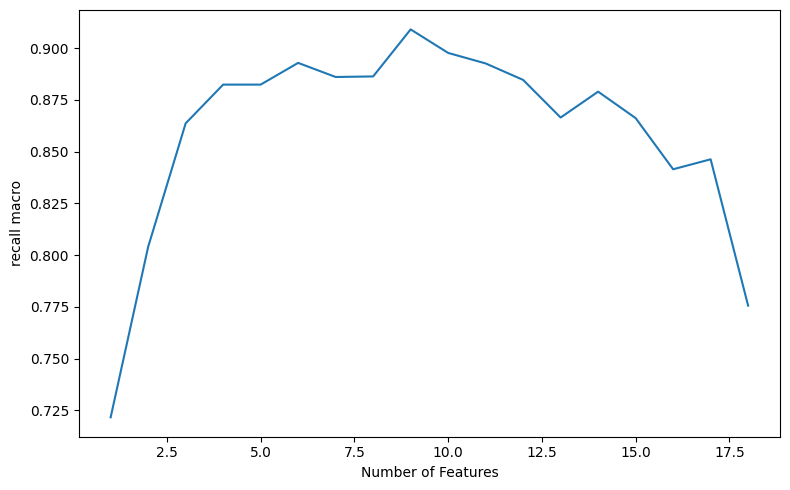

Enter Number of Columns: 9


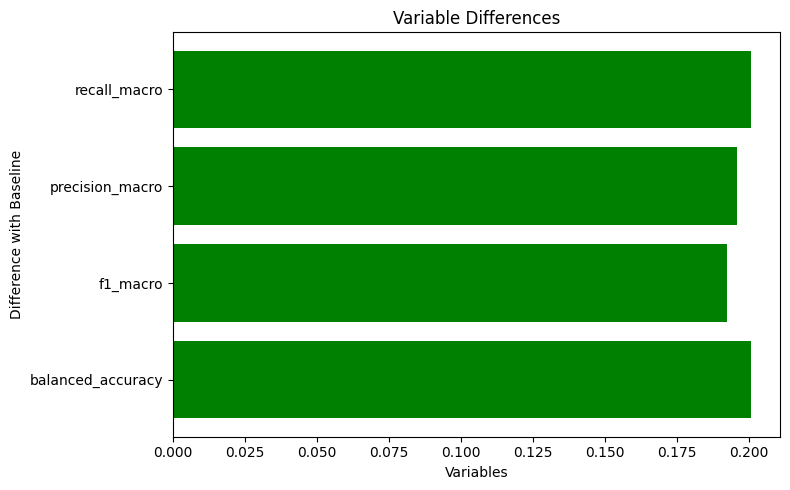

In [16]:
col = dt.columns
features = [0,1]
result= []
mdl = 'ExtraTrees'
classifiers = ExtraTreesClassifier(n_estimators =10, random_state = random_state)
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_extra(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])

### Random Forest

In [17]:
outdir = r'./eval/Embedded/Ensemble'
if not os.path.exists(outdir):
    os.mkdir(outdir)

outdir = r'./eval/Embedded/Ensemble/RandomForest'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
def feat_select_rf(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', RandomForestClassifier(n_estimators =10, random_state = random_state))
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].feature_importances_ for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.696590909090909
134 columns produced macro recall of 0.7807359307359307
59 columns produced macro recall of 0.7676406926406927
30 columns produced macro recall of 0.8028679653679653
16 columns produced macro recall of 0.7866883116883118
9 columns produced macro recall of 0.7150974025974026
5 columns produced macro recall of 0.7244588744588744
3 columns produced macro recall of 0.6957792207792208
2 columns produced macro recall of 0.5622294372294372
2 columns produced macro recall of 0.5622294372294372
2 columns produced macro recall of 0.5622294372294372
2 columns produced macro recall of 0.5622294372294372
2 columns produced macro recall of 0.5622294372294372


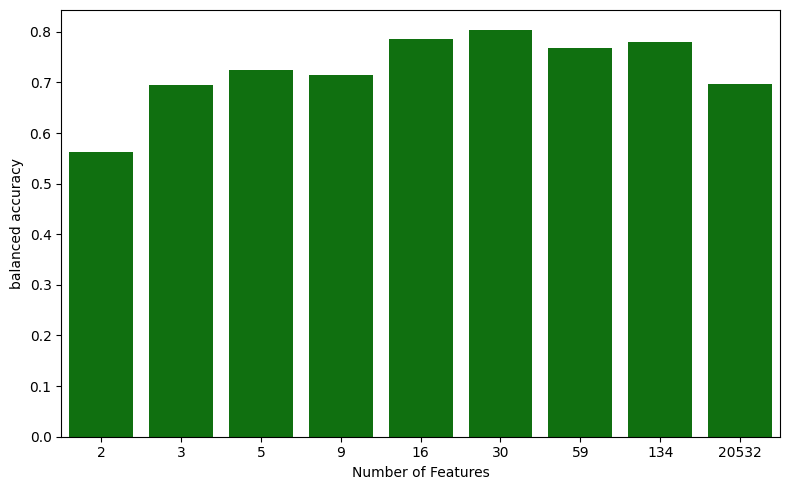

Enter Graph Peak: 30
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


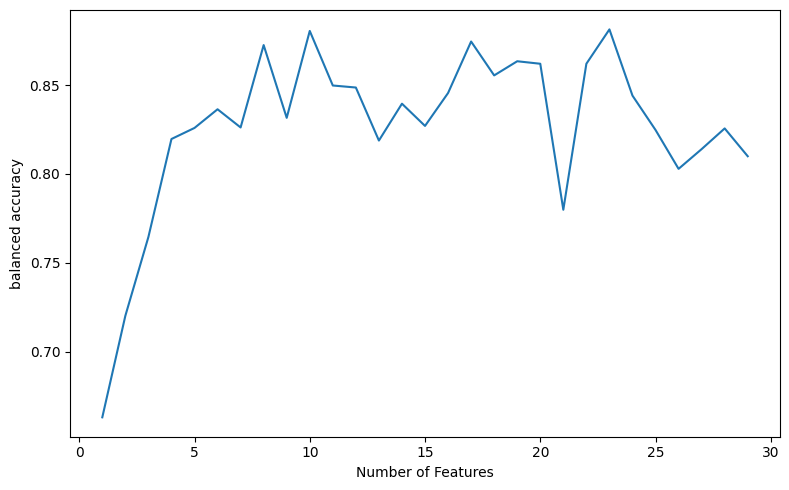

Enter Number of Columns: 8


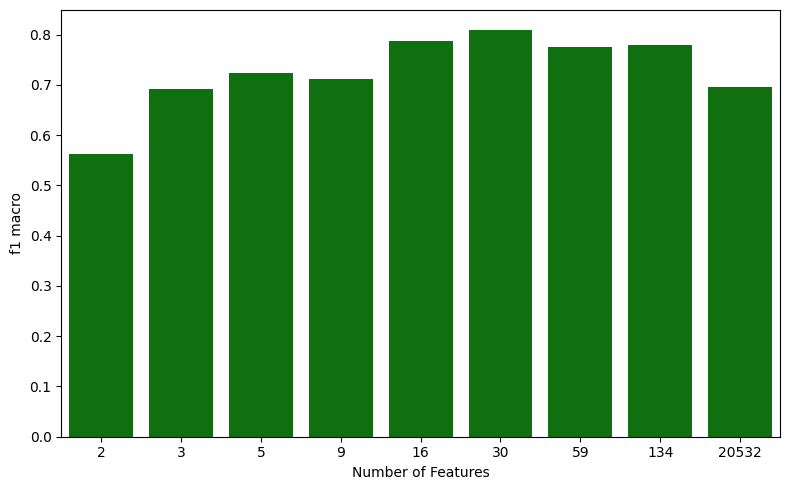

Enter Graph Peak: 30
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


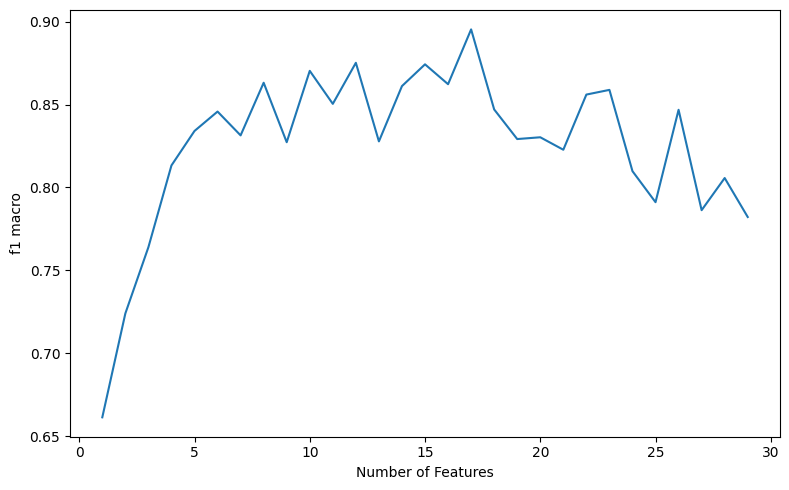

Enter Number of Columns: 6


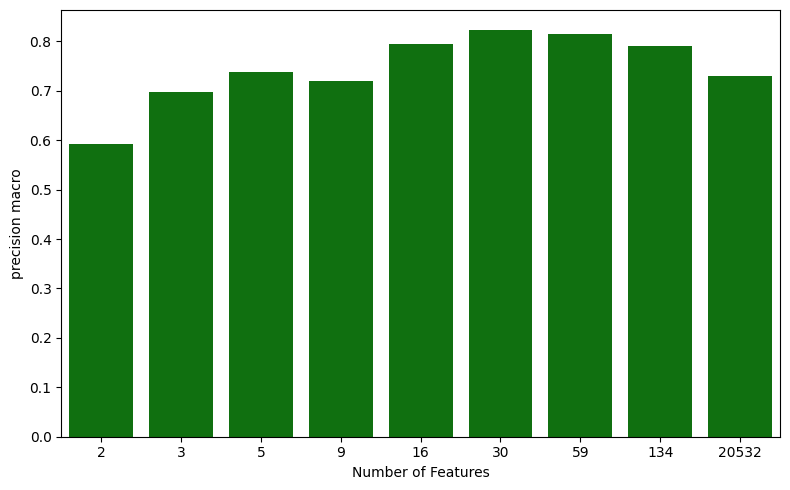

Enter Graph Peak: 30
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


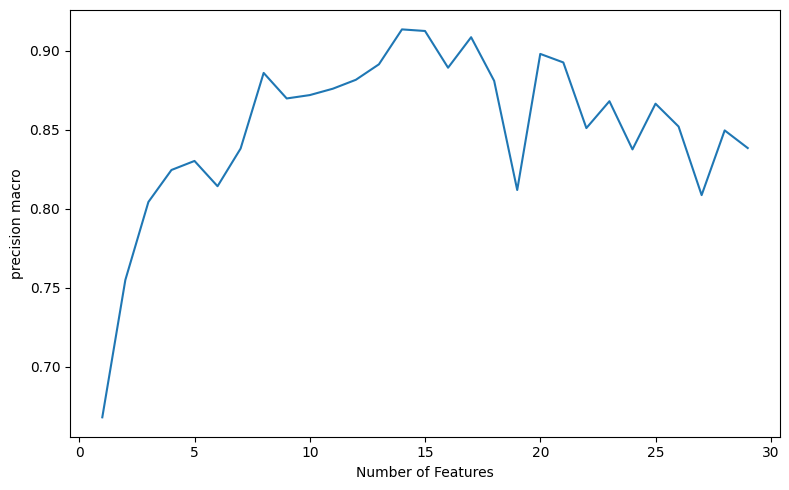

Enter Number of Columns: 8


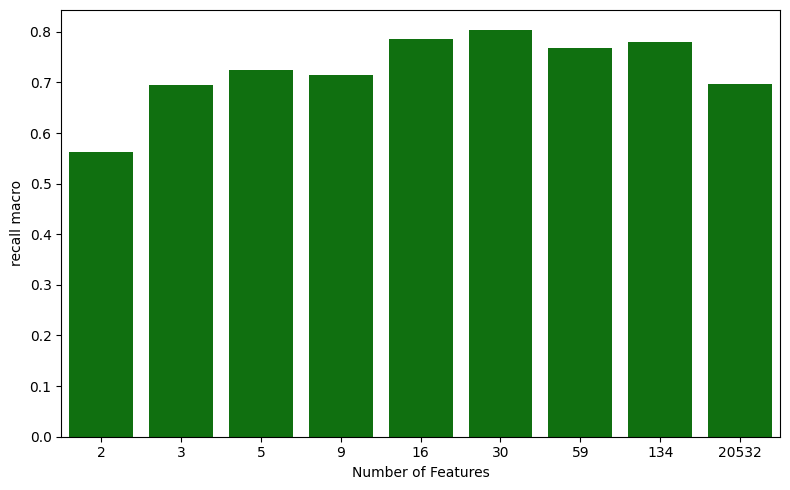

Enter Graph Peak: 30
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


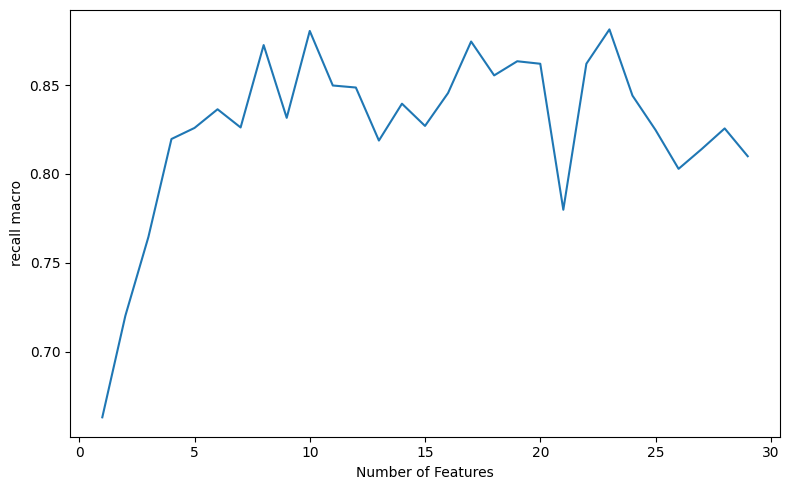

Enter Number of Columns: 8


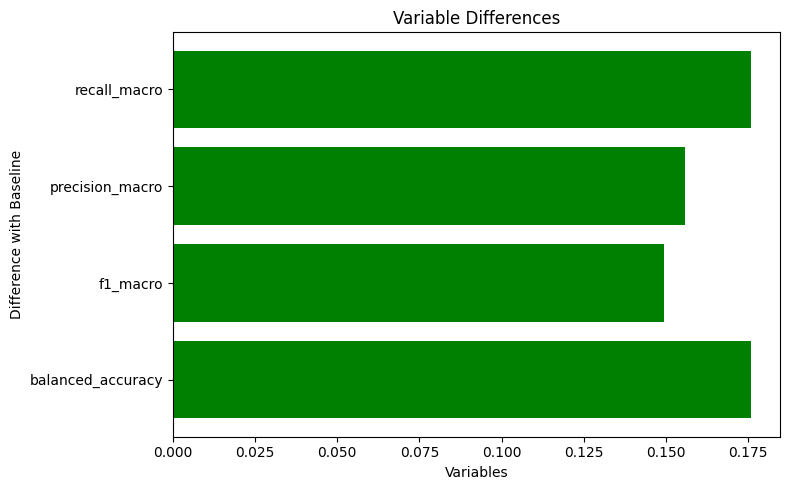

In [19]:
col = dt.columns
features = [0,1]
result= []
mdl = 'RandomForest'
classifiers = RandomForestClassifier(n_estimators =10, random_state = random_state)
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_rf(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])

### AdaBoost

In [21]:
outdir = r'./eval/Embedded/Ensemble'
if not os.path.exists(outdir):
    os.mkdir(outdir)

outdir = r'./eval/Embedded/Ensemble/AdaBoost'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [22]:
from sklearn.ensemble import AdaBoostClassifier
def feat_select_ada(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', AdaBoostClassifier(n_estimators =10, random_state = random_state))
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].feature_importances_ for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.8100108225108225
35 columns produced macro recall of 0.8100108225108225
35 columns produced macro recall of 0.8100108225108225
35 columns produced macro recall of 0.8100108225108225
35 columns produced macro recall of 0.8100108225108225
35 columns produced macro recall of 0.8100108225108225


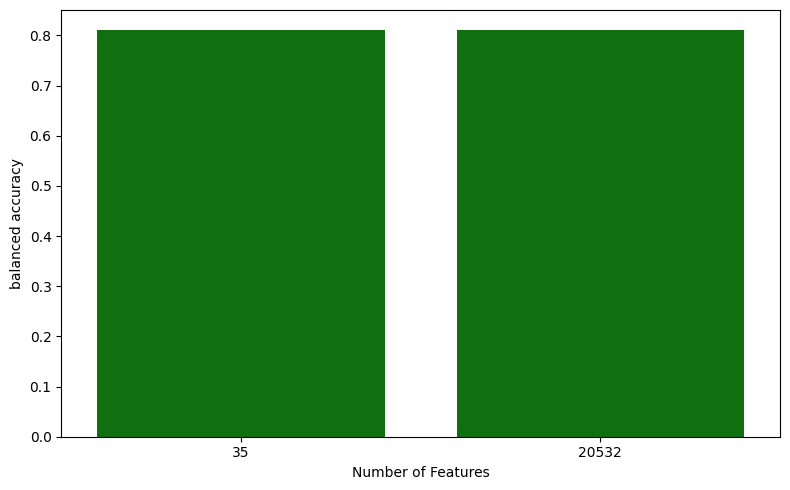

Enter Graph Peak: 35
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


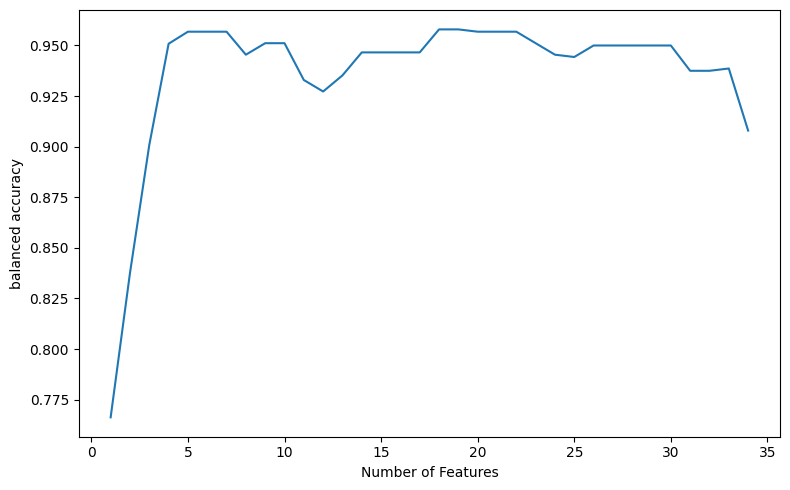

Enter Number of Columns: 4


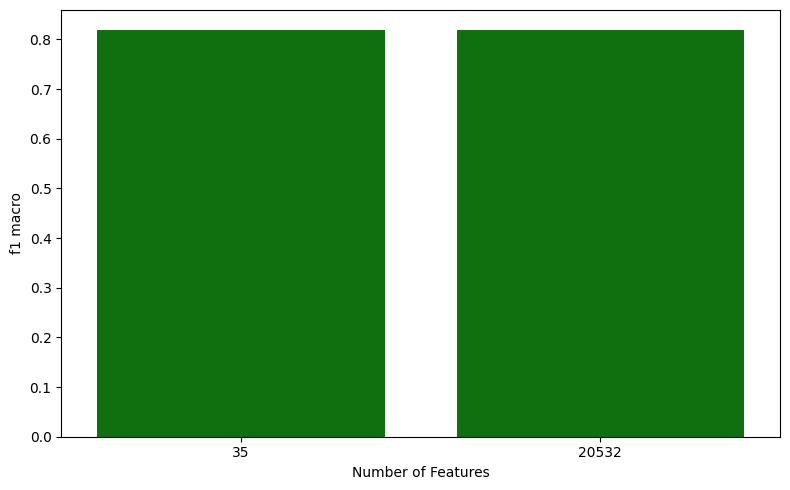

Enter Graph Peak: 35
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


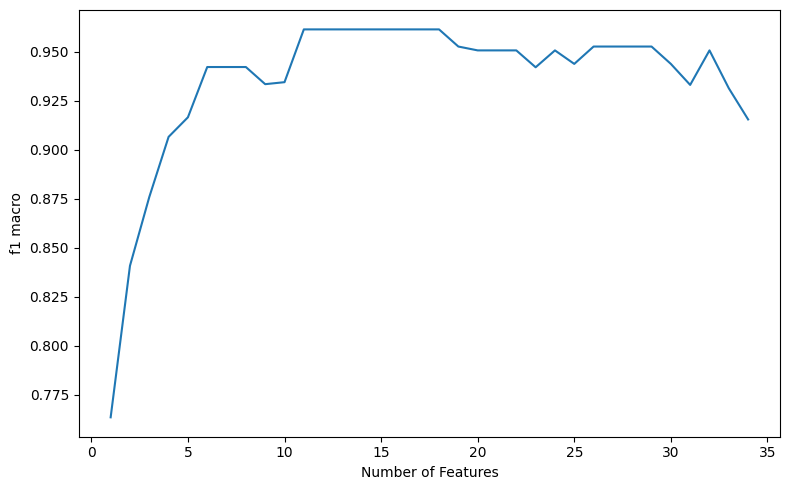

Enter Number of Columns: 6


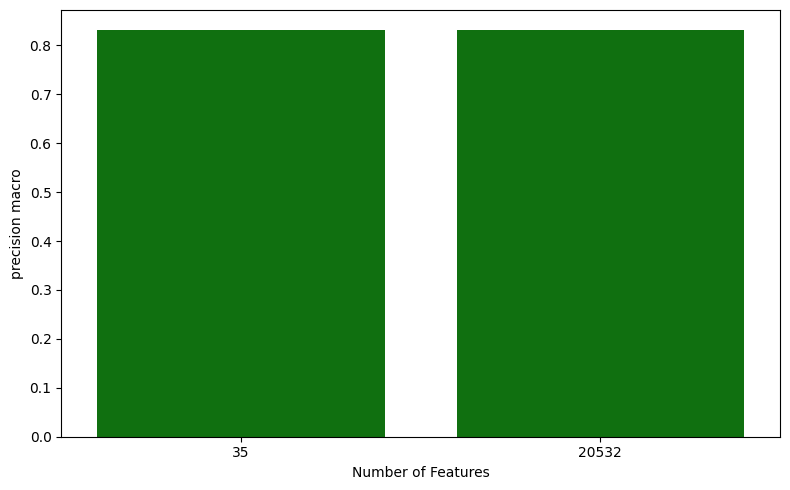

Enter Graph Peak: 35
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


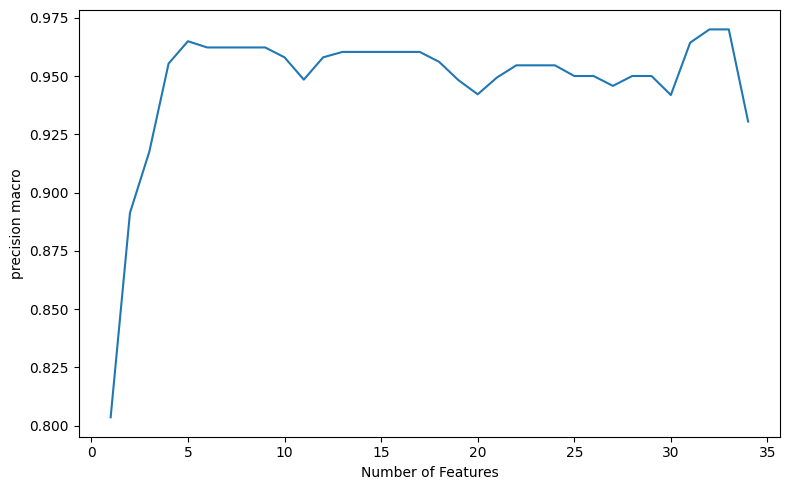

Enter Number of Columns: 5


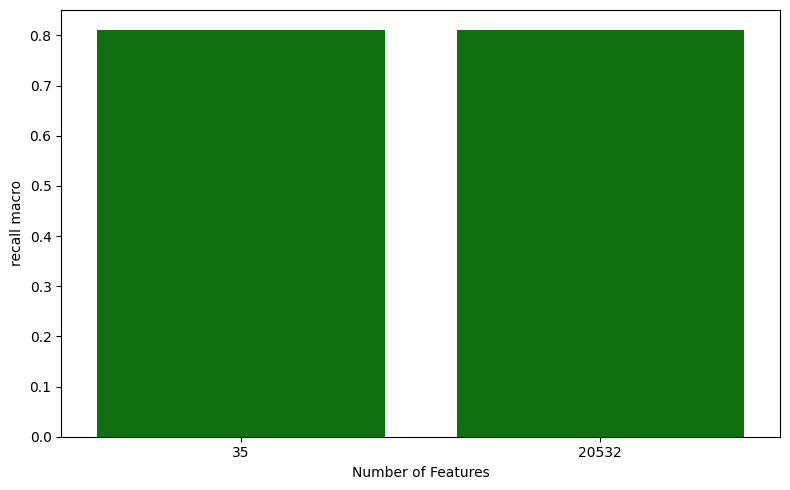

Enter Graph Peak: 35
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


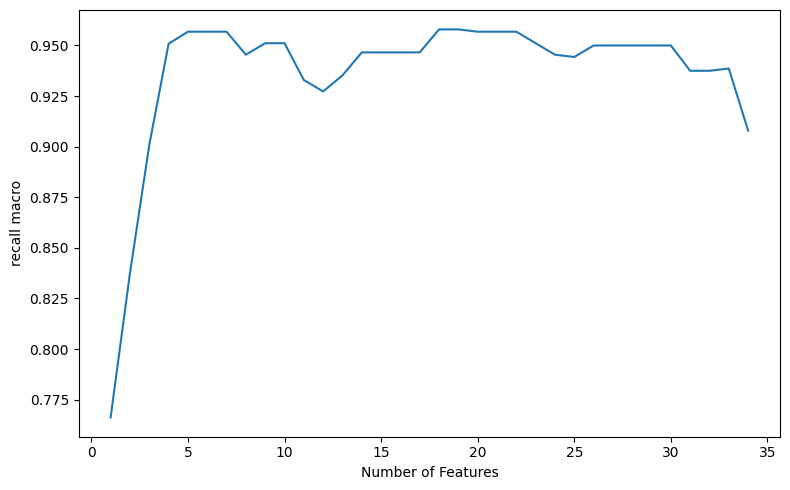

Enter Number of Columns: 5


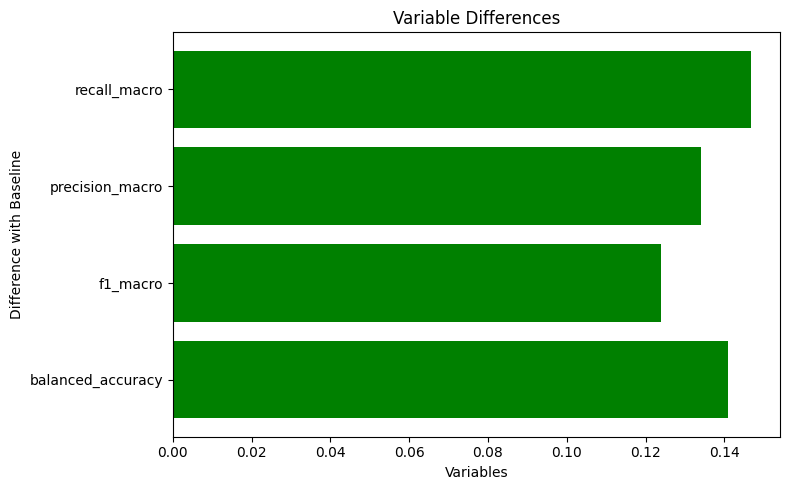

In [23]:
col = dt.columns
features = [0,1]
result= []
mdl = 'AdaBoost'
classifiers = AdaBoostClassifier(n_estimators =10, random_state = random_state)
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_ada(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])

### LGBM

In [27]:
outdir = r'./eval/Embedded/Ensemble'
if not os.path.exists(outdir):
    os.mkdir(outdir)

outdir = r'./eval/Embedded/Ensemble/LGBM'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [28]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
def feat_select_lgbm(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', LGBMClassifier(random_state = random_state))
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].feature_importances_ for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.8460497835497836
562 columns produced macro recall of 0.8392316017316017
445 columns produced macro recall of 0.8392316017316017
418 columns produced macro recall of 0.8517316017316017
403 columns produced macro recall of 0.8517316017316017
403 columns produced macro recall of 0.8517316017316017
403 columns produced macro recall of 0.8517316017316017
403 columns produced macro recall of 0.8517316017316017
403 columns produced macro recall of 0.8517316017316017


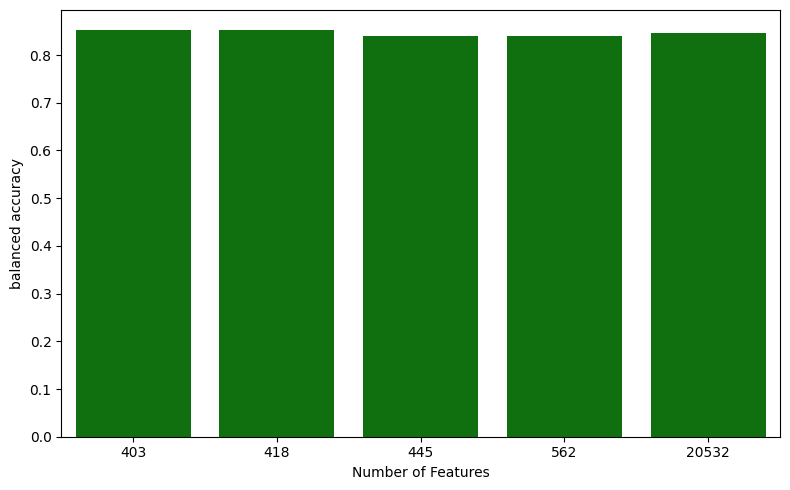

Enter Graph Peak: 403
401 columns left to process
400 columns left to process
399 columns left to process
398 columns left to process
397 columns left to process
396 columns left to process
395 columns left to process
394 columns left to process
393 columns left to process
392 columns left to process
391 columns left to process
390 columns left to process
389 columns left to process
388 columns left to process
387 columns left to process
386 columns left to process
385 columns left to process
384 columns left to process
383 columns left to process
382 columns left to process
381 columns left to process
380 columns left to process
379 columns left to process
378 columns left to process
377 columns left to process
376 columns left to process
375 columns left to process
374 columns left to process
373 columns left to process
372 columns left to process
371 columns left to process
370 columns left to process
369 columns left to process
368 columns left to process
367 columns left to proces

109 columns left to process
108 columns left to process
107 columns left to process
106 columns left to process
105 columns left to process
104 columns left to process
103 columns left to process
102 columns left to process
101 columns left to process
100 columns left to process
99 columns left to process
98 columns left to process
97 columns left to process
96 columns left to process
95 columns left to process
94 columns left to process
93 columns left to process
92 columns left to process
91 columns left to process
90 columns left to process
89 columns left to process
88 columns left to process
87 columns left to process
86 columns left to process
85 columns left to process
84 columns left to process
83 columns left to process
82 columns left to process
81 columns left to process
80 columns left to process
79 columns left to process
78 columns left to process
77 columns left to process
76 columns left to process
75 columns left to process
74 columns left to process
73 columns left to

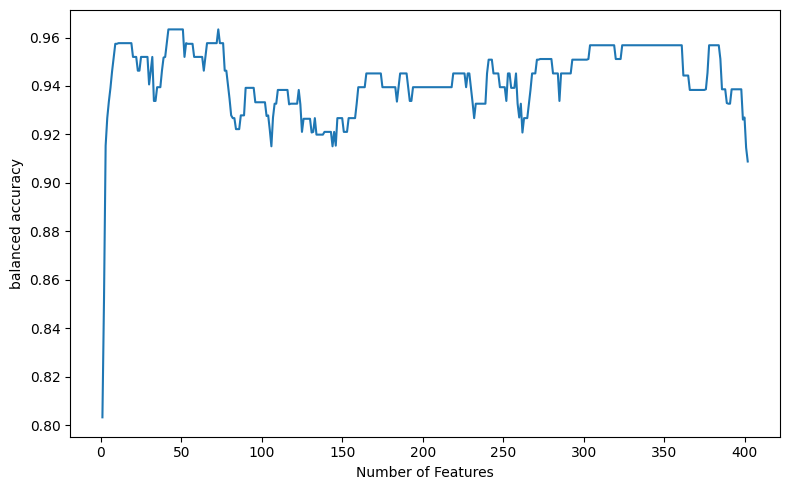

Enter Number of Columns: 10


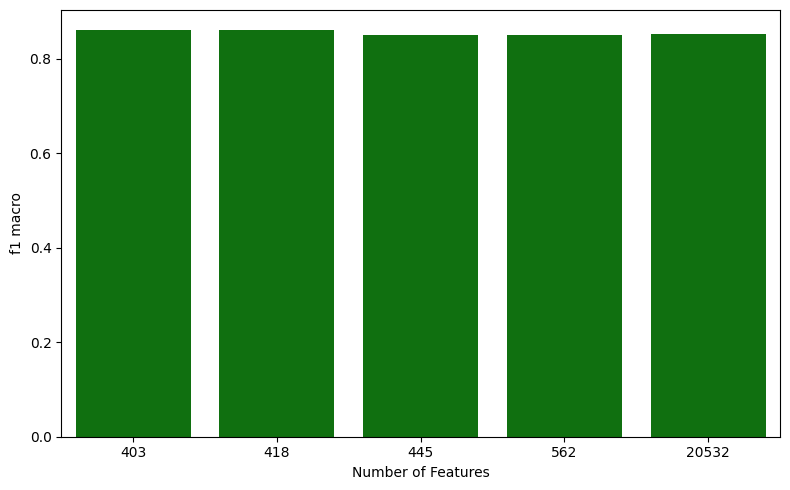

Enter Graph Peak: 403
401 columns left to process
400 columns left to process
399 columns left to process
398 columns left to process
397 columns left to process
396 columns left to process
395 columns left to process
394 columns left to process
393 columns left to process
392 columns left to process
391 columns left to process
390 columns left to process
389 columns left to process
388 columns left to process
387 columns left to process
386 columns left to process
385 columns left to process
384 columns left to process
383 columns left to process
382 columns left to process
381 columns left to process
380 columns left to process
379 columns left to process
378 columns left to process
377 columns left to process
376 columns left to process
375 columns left to process
374 columns left to process
373 columns left to process
372 columns left to process
371 columns left to process
370 columns left to process
369 columns left to process
368 columns left to process
367 columns left to proces

109 columns left to process
108 columns left to process
107 columns left to process
106 columns left to process
105 columns left to process
104 columns left to process
103 columns left to process
102 columns left to process
101 columns left to process
100 columns left to process
99 columns left to process
98 columns left to process
97 columns left to process
96 columns left to process
95 columns left to process
94 columns left to process
93 columns left to process
92 columns left to process
91 columns left to process
90 columns left to process
89 columns left to process
88 columns left to process
87 columns left to process
86 columns left to process
85 columns left to process
84 columns left to process
83 columns left to process
82 columns left to process
81 columns left to process
80 columns left to process
79 columns left to process
78 columns left to process
77 columns left to process
76 columns left to process
75 columns left to process
74 columns left to process
73 columns left to

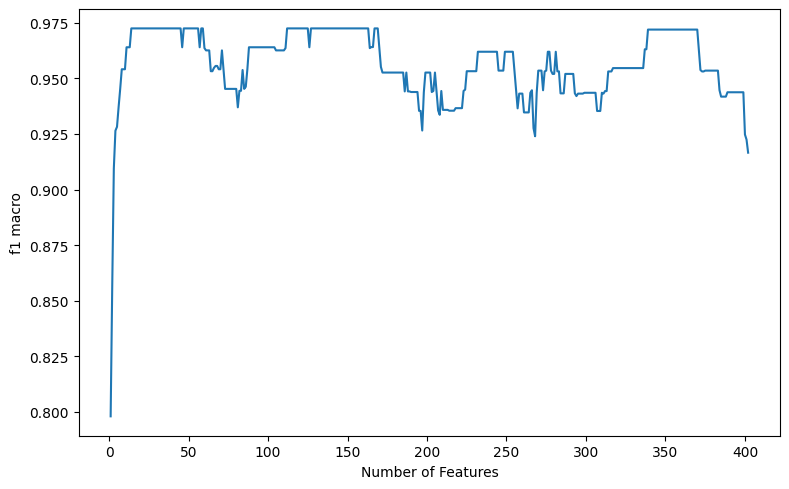

Enter Number of Columns: 5


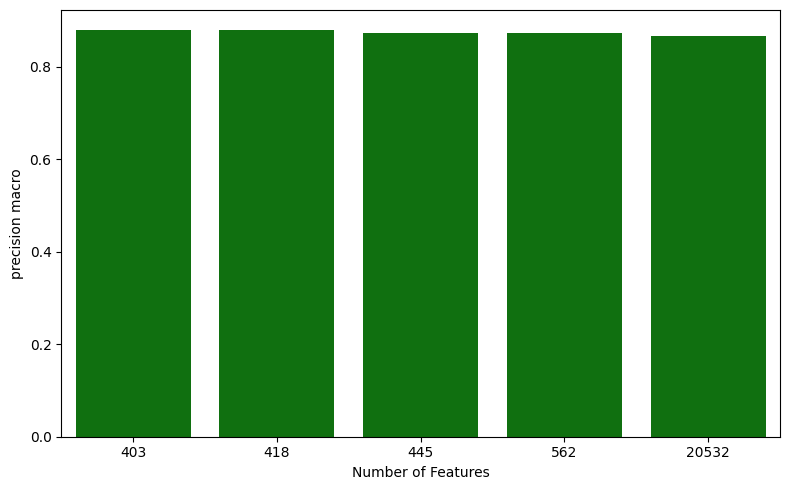

Enter Graph Peak: 403
401 columns left to process
400 columns left to process
399 columns left to process
398 columns left to process
397 columns left to process
396 columns left to process
395 columns left to process
394 columns left to process
393 columns left to process
392 columns left to process
391 columns left to process
390 columns left to process
389 columns left to process
388 columns left to process
387 columns left to process
386 columns left to process
385 columns left to process
384 columns left to process
383 columns left to process
382 columns left to process
381 columns left to process
380 columns left to process
379 columns left to process
378 columns left to process
377 columns left to process
376 columns left to process
375 columns left to process
374 columns left to process
373 columns left to process
372 columns left to process
371 columns left to process
370 columns left to process
369 columns left to process
368 columns left to process
367 columns left to proces

109 columns left to process
108 columns left to process
107 columns left to process
106 columns left to process
105 columns left to process
104 columns left to process
103 columns left to process
102 columns left to process
101 columns left to process
100 columns left to process
99 columns left to process
98 columns left to process
97 columns left to process
96 columns left to process
95 columns left to process
94 columns left to process
93 columns left to process
92 columns left to process
91 columns left to process
90 columns left to process
89 columns left to process
88 columns left to process
87 columns left to process
86 columns left to process
85 columns left to process
84 columns left to process
83 columns left to process
82 columns left to process
81 columns left to process
80 columns left to process
79 columns left to process
78 columns left to process
77 columns left to process
76 columns left to process
75 columns left to process
74 columns left to process
73 columns left to

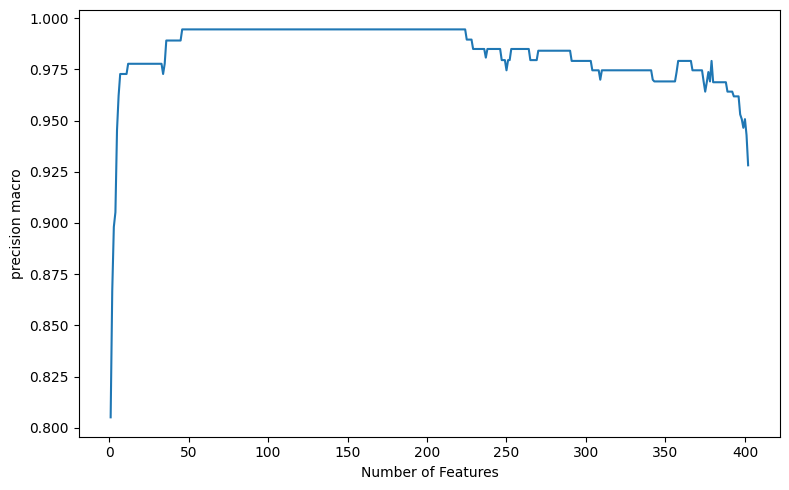

Enter Number of Columns: 8


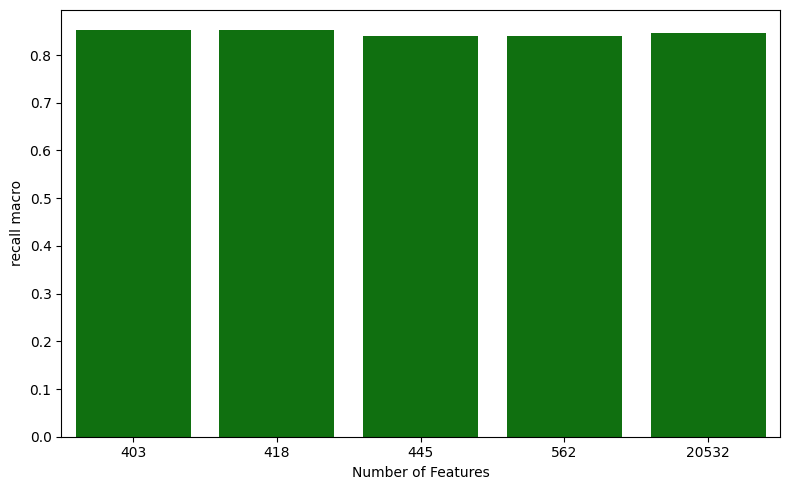

Enter Graph Peak: 403
401 columns left to process
400 columns left to process
399 columns left to process
398 columns left to process
397 columns left to process
396 columns left to process
395 columns left to process
394 columns left to process
393 columns left to process
392 columns left to process
391 columns left to process
390 columns left to process
389 columns left to process
388 columns left to process
387 columns left to process
386 columns left to process
385 columns left to process
384 columns left to process
383 columns left to process
382 columns left to process
381 columns left to process
380 columns left to process
379 columns left to process
378 columns left to process
377 columns left to process
376 columns left to process
375 columns left to process
374 columns left to process
373 columns left to process
372 columns left to process
371 columns left to process
370 columns left to process
369 columns left to process
368 columns left to process
367 columns left to proces

109 columns left to process
108 columns left to process
107 columns left to process
106 columns left to process
105 columns left to process
104 columns left to process
103 columns left to process
102 columns left to process
101 columns left to process
100 columns left to process
99 columns left to process
98 columns left to process
97 columns left to process
96 columns left to process
95 columns left to process
94 columns left to process
93 columns left to process
92 columns left to process
91 columns left to process
90 columns left to process
89 columns left to process
88 columns left to process
87 columns left to process
86 columns left to process
85 columns left to process
84 columns left to process
83 columns left to process
82 columns left to process
81 columns left to process
80 columns left to process
79 columns left to process
78 columns left to process
77 columns left to process
76 columns left to process
75 columns left to process
74 columns left to process
73 columns left to

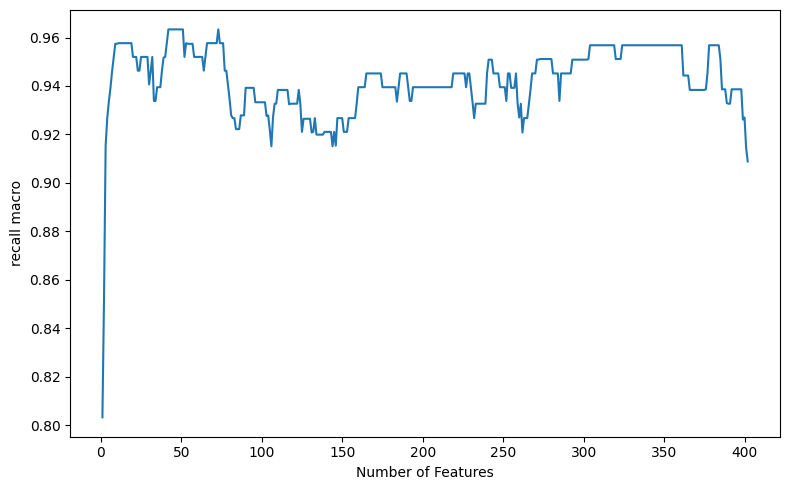

In [ ]:
col = dt.columns
features = [0,1]
result= []
mdl = 'lgbm'
classifiers = LGBMClassifier(random_state = random_state)
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_lgbm(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])

### SVC

In [24]:
outdir = r'./eval/Embedded/Others'
if not os.path.exists(outdir):
    os.mkdir(outdir)

outdir = r'./eval/Embedded/Others/SVC'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [25]:
from sklearn.svm import SVC
def feat_select_svc(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', SVC(kernel='linear'))
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].coef_[0] for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

20532 columns produced macro recall of 0.7642316017316017
10027 columns produced macro recall of 0.9409090909090909
5015 columns produced macro recall of 0.9761363636363637
2509 columns produced macro recall of 1.0
1255 columns produced macro recall of 1.0
628 columns produced macro recall of 1.0
315 columns produced macro recall of 1.0
158 columns produced macro recall of 1.0
80 columns produced macro recall of 0.9886363636363636
41 columns produced macro recall of 1.0
21 columns produced macro recall of 0.9875
12 columns produced macro recall of 0.9397727272727272
7 columns produced macro recall of 0.8875
5 columns produced macro recall of 0.8735930735930737
3 columns produced macro recall of 0.7770021645021645
3 columns produced macro recall of 0.7770021645021645
3 columns produced macro recall of 0.7770021645021645
3 columns produced macro recall of 0.7770021645021645
3 columns produced macro recall of 0.7770021645021645


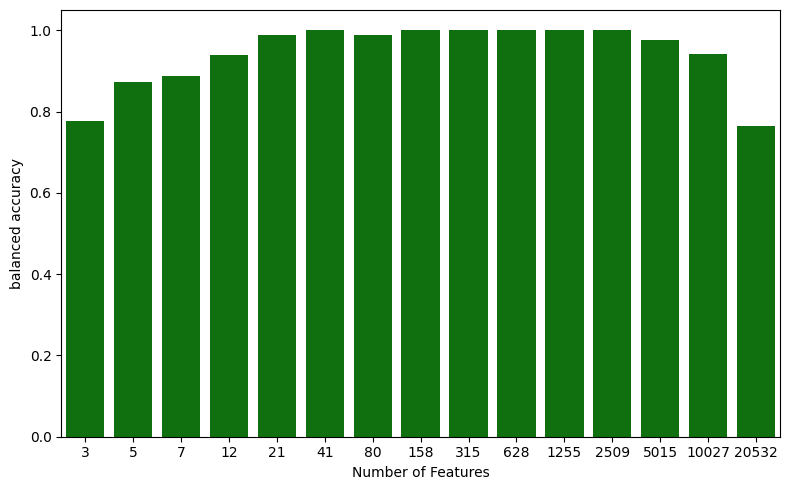

Enter Graph Peak: 21
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 columns left to process
1 columns left to process


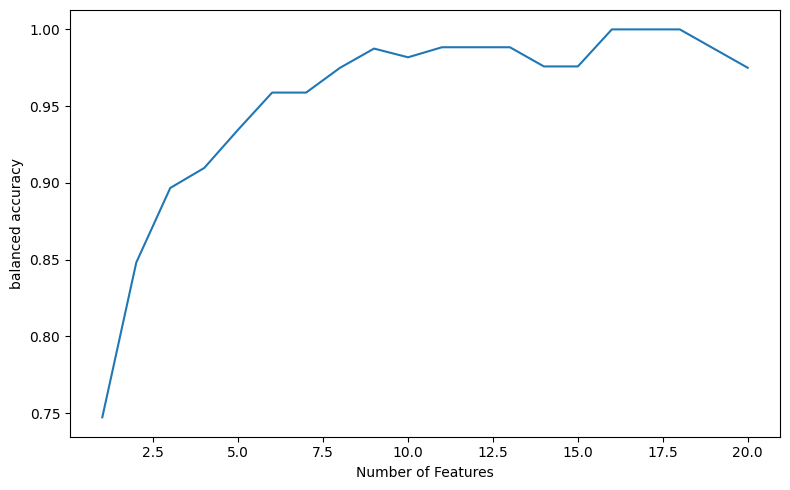

Enter Number of Columns: 9


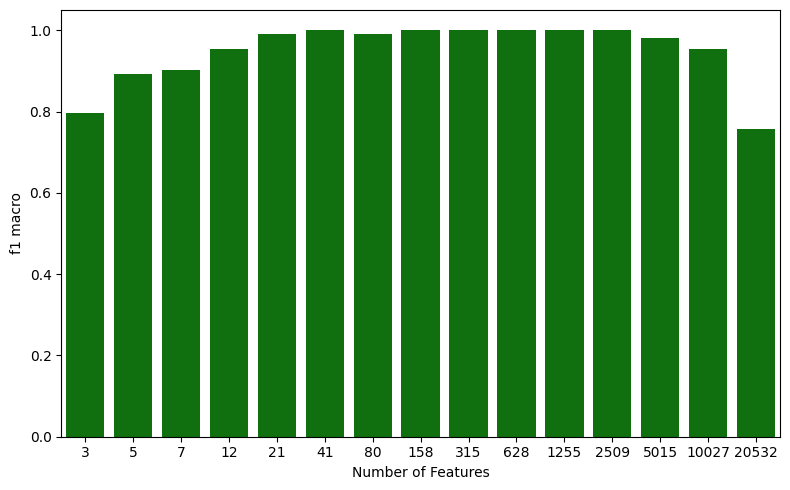

Enter Graph Peak: 41
39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns lef

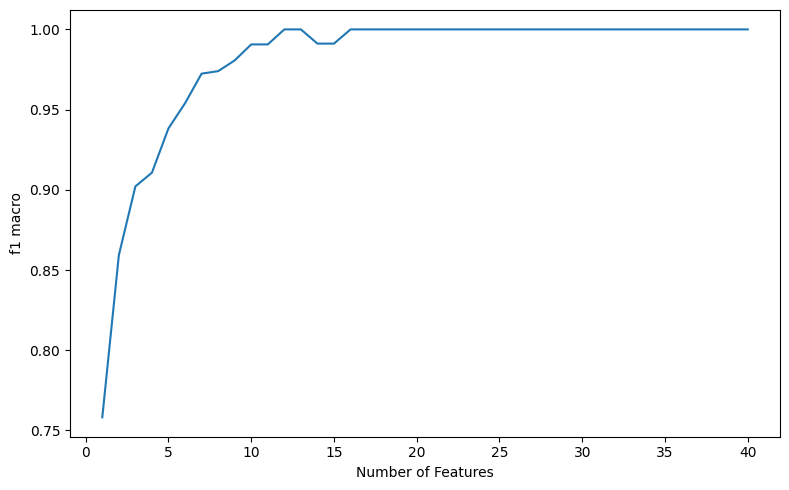

Enter Number of Columns: 8


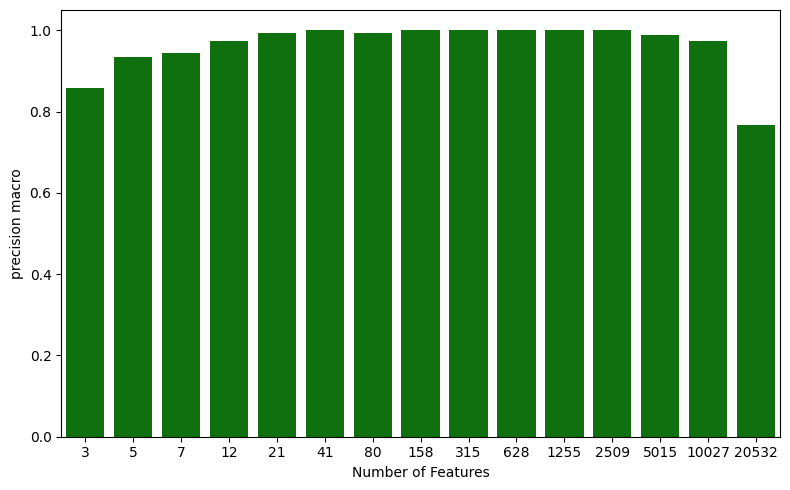

Enter Graph Peak: 41
39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns lef

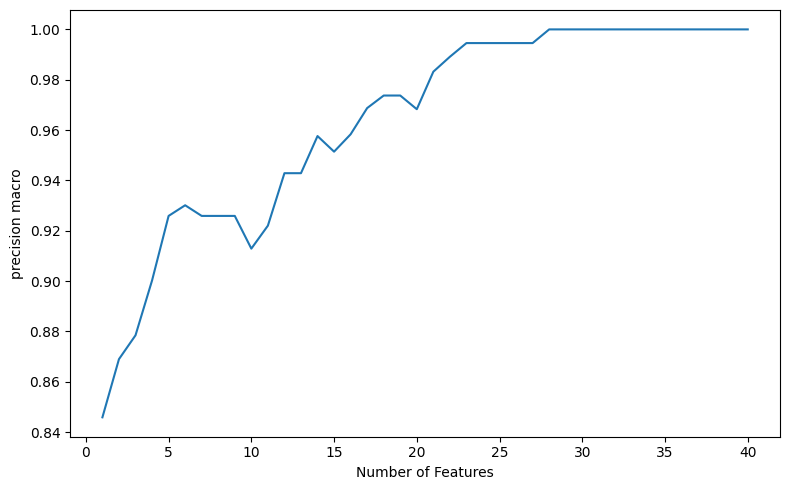

Enter Number of Columns: 5


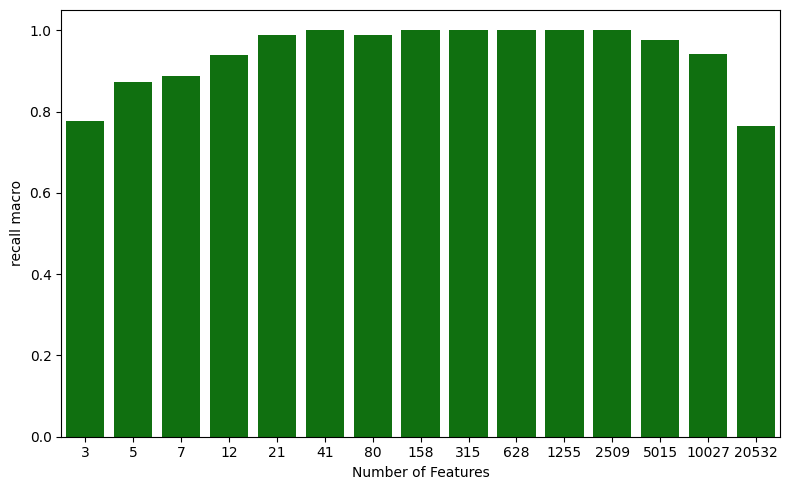

Enter Graph Peak: 41
39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns lef

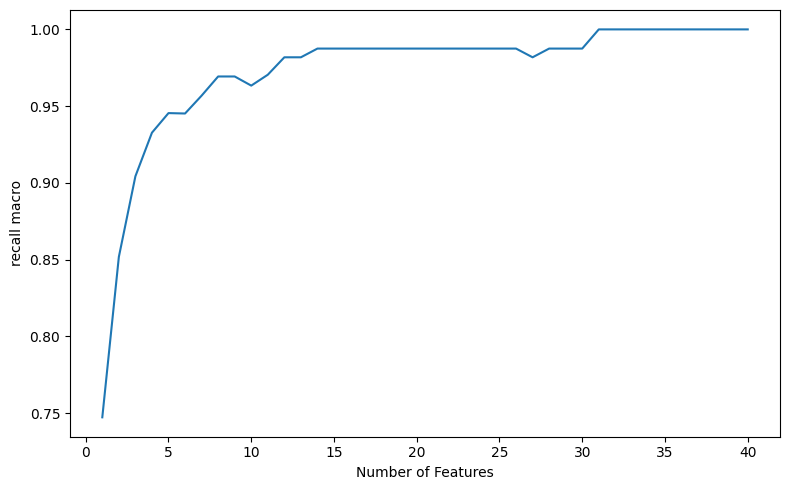

Enter Number of Columns: 8


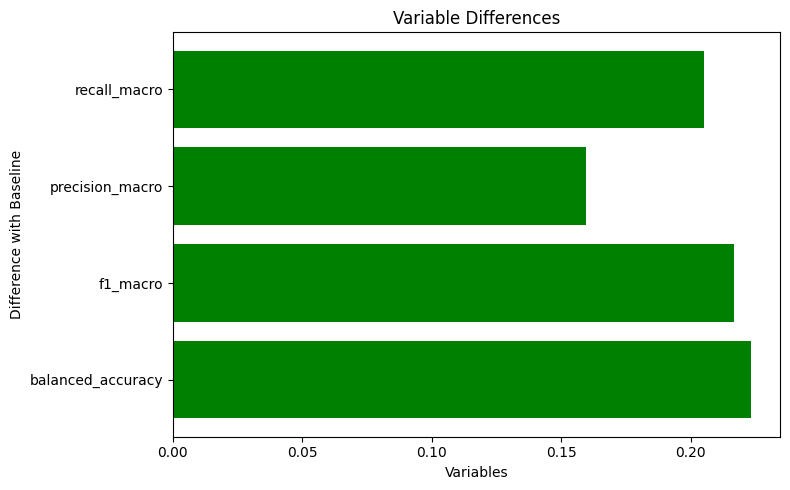

In [26]:
col = dt.columns
features = [0,1]
result= []
mdl = 'svc'
classifiers = SVC(kernel='linear')
f_res = {}

while len(set(features[-5:])) != 1:
    res = feat_select_svc(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']
    
int_res = intermediate_results(res,mdl)
# pp.savefig(os.path.join(outdir, f'{mdl}_stage1_result_with_{use_score}.png'), dpi=300, bbox_inches='tight')
int_res.to_csv(os.path.join(outdir,f'{mdl}_stage1_result.csv'),index=False)

for use_score in [x for x in int_res.columns if x != 'features'] :
    intermediate_plot(int_res,scorer=use_score,mdl=mdl)

    while True:
        try:
            peak = int(input("Enter Graph Peak: "))
            break  # Break out of the loop if a valid integer is entered
        except ValueError:
            print("Invalid input. Please enter an integer.")

    bestcols = []
    cols = [x for x in result if x['features'] == peak][0]['cols']
    features = dt[cols].copy()
    target = features.pop('Label')
    cols = features.columns.tolist()
    feed_forward(cols,bestcols,use_score,classifiers)

    final_res,score = final_results(bestcols,result,scoring=use_score,mdl = mdl)
    f_res[use_score] = score
    final_res.to_csv(os.path.join(outdir,f'{mdl}_stage2_result_with_{use_score}.csv'),index=False)
    
plot_difference(f_res,int_res.head(1)[f_res.keys()].to_dict(orient='records')[0])